Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 16.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.4 MB/s 
     |████████████████████████████████| 6.6 MB 73.3 MB/s 
     |████████████████████████████████| 120 kB 54.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=54ab32819b7847cf8d8c18493114f81fcf0a9195f69da103eb4267dbfcc8d3d0
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1FllL2kWZ5q1E0alqyLz7TGC1qlKYwJxN'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1pJS8Cc_AeixyHXgXm9uB_KaboX5E-G40'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1IYIIMhI1uQNjxlp9D4WzEBKLk20gE6RC'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1817
Number of dev sentences:  321
Number of test sentences:  378
Number of words in the training dataset:  11597
Number of words in the dev dataset:  4202
Number of words in the test dataset:  5076
Tags in the training dataset: ['I-LEGISLACAO', 'O', 'B-LEGISLACAO']
Number of Labels in the training dataset:  3
Tags in the dev dataset: ['I-LEGISLACAO', 'O', 'B-LEGISLACAO']
Number of Labels in the dev dataset:  3
Tags in the test dataset: ['I-LEGISLACAO', 'O', 'B-LEGISLACAO']
Number of Labels in the test dataset:  3
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 671,“,O
1,Sentence: 671,Agravo,O
2,Sentence: 671,regimental,O
3,Sentence: 671,em,O
4,Sentence: 671,habeas,O
5,Sentence: 671,corpus,O
6,Sentence: 671,.,O
7,Sentence: 671,Homicídio,O
8,Sentence: 671,qualificado,O
9,Sentence: 671,(,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('em', 'O'),
 ('seus', 'O'),
 ('votos', 'O'),
 ('os', 'O'),
 ('argumentos', 'O'),
 ('de', 'O'),
 ('ambas', 'O'),
 ('as', 'O'),
 ('partes', 'O'),
 (',', 'O'),
 ('não', 'O'),
 ('havendo', 'O'),
 ('reconhecer', 'O'),
 (',', 'O'),
 ('agora', 'O'),
 (',', 'O'),
 ('quaisquer', 'O'),
 ('dos', 'O'),
 ('vícios', 'O'),
 ('do', 'O'),
 ('art.', 'B-LEGISLACAO'),
 ('1.022', 'I-LEGISLACAO'),
 (',', 'O'),
 ('do', 'O'),
 ('Código', 'B-LEGISLACAO'),
 ('de', 'I-LEGISLACAO'),
 ('Processo', 'I-LEGISLACAO'),
 ('Civil', 'I-LEGISLACAO'),
 ('.', 'O')]

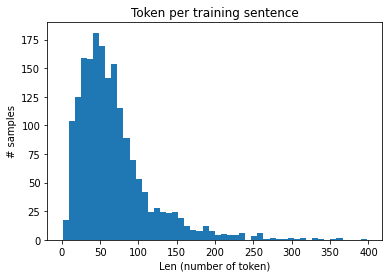

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

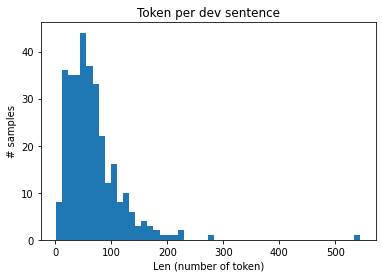

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

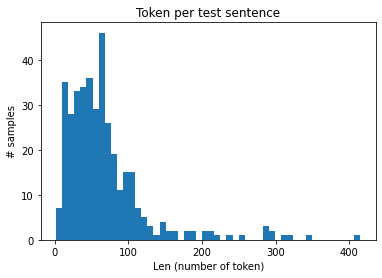

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'civil'
print(word2idx['civil'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-LEGISLACAO'
print(tag2idx['B-LEGISLACAO'])
# Tag of index 0
print(idx2tag[0])

791
sistematicamente
2
I-LEGISLACAO


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.25)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1817
Points in y_train before removal: 1817
Points in X_train before removal: 1363
Points in y_train before removal: 1363


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[13008, 1892, 11449, 7715, 2197, 12577, 6247, 12939, 1598, 12939, 2488, 1794, 7026, 13372, 2840, 11588, 12939, 7105, 7026, 7072, 13303, 2840, 3861, 12939, 4480, 1453, 2840, 1676, 2840, 11289, 12939, 4480, 9416, 12939, 7072, 1794, 12939, 2353, 1892, 2840, 3736, 12939, 7072, 13329, 2840, 7026, 7579, 12939, 4480, 9416, 12939, 2773, 5313, 2705, 13322]
[1, 1, 1, 1, 1, 2, 0, 1, 2, 1, 2, 0, 1, 2, 1, 2, 1, 2, 1, 2, 0, 1, 2, 1, 2, 0, 1, 2, 1, 2, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 1, 2, 0, 1, 1, 2, 1, 2, 0, 1, 1, 2, 0, 1]
[4444, 274, 12939, 9515, 13571, 4081, 11623, 7720, 4304, 7785, 11348, 13536, 1578, 2078, 9379, 7785, 155, 7785, 13402, 10016, 12939, 11393, 386, 12415, 3392, 894, 6047, 9443, 2901, 7785, 9959, 527, 8066, 1830, 12674, 4004, 1391, 13515, 7785, 2087, 10668, 6047, 231, 12939, 6047, 1140, 12939, 1283, 7026, 6047, 13467, 5548, 12753, 1943, 2773, 9642, 7595, 8753, 8737, 11478, 12939, 7105, 12939, 2773, 1182, 10379, 2840, 8737, 10290, 2773, 1182, 1573, 7026, 8737, 7855, 7322, 6061, 2245,

In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 15.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 14.1 MB/s 
     |████████████████████████████████| 6.6 MB 77.9 MB/s 
     |████████████████████████████████| 120 kB 88.6 MB/s 


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=ca0492a89034c7ce9e4b13248a7ec1a6acf6399a2a6e29b307c8c60d6574aa3a
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[13008, 1892, 11449, 7715, 2197, 12577, 6247, 12939, 1598, 12939, 2488, 1794, 7026, 13372, 2840, 11588, 12939, 7105, 7026, 7072, 13303, 2840, 3861, 12939, 4480, 1453, 2840, 1676, 2840, 11289, 12939, 4480, 9416, 12939, 7072, 1794, 12939, 2353, 1892, 2840, 3736, 12939, 7072, 13329, 2840, 7026, 7579, 12939, 4480, 9416, 12939, 2773, 5313, 2705, 13322]
[1, 1, 1, 1, 1, 2, 0, 1, 2, 1, 2, 0, 1, 2, 1, 2, 1, 2, 1, 2, 0, 1, 2, 1, 2, 0, 1, 2, 1, 2, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 1, 2, 0, 1, 1, 2, 1, 2, 0, 1, 1, 2, 0, 1]
[4444, 274, 12939, 9515, 13571, 4081, 11623

In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [6]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [7]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [8]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [9]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1363
Points in y_train after augmentation: 1363
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1917670965194702
Training loss epoch: 0.09366982500745677
Training accuracy epoch: 0.9678836875413797
Validating model...
Validation Loss: 0.01833151959414993
Validation Accuracy: 0.9942833059597562
Training epoch: 2
Training loss per 100 training steps: 0.013418718241155148
Training loss epoch: 0.016878761161595236
Training accuracy epoch: 0.995072921771139
Validating model...
Validation Loss: 0.01591751027098369
Validation Accuracy: 0.9954942422479311
Training epoch: 3
Training loss per 100 training steps: 0.00769213167950511
Training loss epoch: 0.00974794331671356
Training accuracy epoch: 0.9972732988576025
Validating model...
Validation Loss: 0.02004656360978039
Validation Accuracy: 0.9943555348857345
Training epoch: 4
Training loss per 100 training steps: 0.01707800105214119
Training loss epoch: 0.008382364112252998
Training accuracy epoch: 0.9975417224624366
Validating model...
Validation Loss: 0.013268739770172119
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013402060216321843
Validation Accuracy: 0.9970355036631776
Validation duration: 0.07845285000000028 minutes
F1-score (test): 98.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.98      0.98      0.98      1238

   micro avg       0.98      0.98      0.98      1238
   macro avg       0.98      0.98      0.98      1238
weighted avg       0.98      0.98      0.98      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1363
Points in y_train after augmentation: 1363
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.152069091796875
Training loss epoch: 0.08967383536726756
Training accuracy epoch: 0.9693214003007793
Validating model...
Validation Loss: 0.020924535956943317
Validation Accuracy: 0.9938622385009148
Training epoch: 2
Training loss per 100 training steps: 0.014506575651466846
Training loss epoch: 0.016793457087302625
Training accuracy epoch: 0.994953327011137
Validating model...
Validation Loss: 0.013183704796358057
Validation Accuracy: 0.996282800423209
Training epoch: 3
Training loss per 100 training steps: 0.007245290093123913
Training loss epoch: 0.010280065738655584
Training accuracy epoch: 0.9967892526604366
Validating model...
Validation Loss: 0.016214277920967322
Validation Accuracy: 0.9949940378039824
Training epoch: 4
Training loss per 100 training steps: 0.006241297349333763
Training loss epoch: 0.00533777556035581
Training accuracy epoch: 0.9984039165645575
Validating model...
Validation Loss: 0.010315827401687525
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.012874586446438721
Validation Accuracy: 0.9968031072591033
Validation duration: 0.07787069999999971 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1363
Points in y_train after augmentation: 1363
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2034944295883179
Training loss epoch: 0.08483786077433547
Training accuracy epoch: 0.9695937417269049
Validating model...
Validation Loss: 0.022720916684539544
Validation Accuracy: 0.9928224650481513
Training epoch: 2
Training loss per 100 training steps: 0.009320605546236038
Training loss epoch: 0.016094393186206216
Training accuracy epoch: 0.9952447360399548
Validating model...
Validation Loss: 0.013783016571930299
Validation Accuracy: 0.995912259815386
Training epoch: 3
Training loss per 100 training steps: 0.006100691854953766
Training loss epoch: 0.008545718708097241
Training accuracy epoch: 0.9975235703659047
Validating model...
Validation Loss: 0.012040468310477167
Validation Accuracy: 0.9968086829147069
Training epoch: 4
Training loss per 100 training steps: 0.0029771612025797367
Training loss epoch: 0.005350355836928302
Training accuracy epoch: 0.9982776452435693
Validating model...
Validation Loss: 0.01802525344482135


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.010835545015045986
Validation Accuracy: 0.9965760918982466
Validation duration: 0.07962213333333162 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1363
Points in y_train after augmentation: 1363
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1393346786499023
Training loss epoch: 0.093929088912731
Training accuracy epoch: 0.968248002206005
Validating model...
Validation Loss: 0.016246764765431482
Validation Accuracy: 0.9952484558847422
Training epoch: 2
Training loss per 100 training steps: 0.007896767929196358
Training loss epoch: 0.013894087781176664
Training accuracy epoch: 0.9959013765456539
Validating model...
Validation Loss: 0.042490947902912184
Validation Accuracy: 0.9876750021186876
Training epoch: 3
Training loss per 100 training steps: 0.009551076218485832
Training loss epoch: 0.010387191718151835
Training accuracy epoch: 0.9967840523982066
Validating model...
Validation Loss: 0.016179883356450035
Validation Accuracy: 0.9955434281787855
Training epoch: 4
Training loss per 100 training steps: 0.01575198955833912
Training loss epoch: 0.006074359013223858
Training accuracy epoch: 0.9982518173479116
Validating model...
Validation Loss: 0.019519876497465054
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01167571083654669
Validation Accuracy: 0.9972161488263368
Validation duration: 0.07812133333333122 minutes
F1-score (test): 98.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1363
Points in y_train after augmentation: 1363
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.010298252105713
Training loss epoch: 0.08596727153459607
Training accuracy epoch: 0.9727289979095484
Validating model...
Validation Loss: 0.016922677833853022
Validation Accuracy: 0.9947780815012405
Training epoch: 2
Training loss per 100 training steps: 0.03192771598696709
Training loss epoch: 0.014938294752176071
Training accuracy epoch: 0.9955402100210071
Validating model...
Validation Loss: 0.012916252859646366
Validation Accuracy: 0.9965734530657648
Training epoch: 3
Training loss per 100 training steps: 0.01803576946258545
Training loss epoch: 0.009560583993186092
Training accuracy epoch: 0.9970014051976162
Validating model...
Validation Loss: 0.01258500017311668
Validation Accuracy: 0.9964737321832913
Training epoch: 4
Training loss per 100 training steps: 0.007119276095181704
Training loss epoch: 0.004867794257818808
Training accuracy epoch: 0.9985204959671712
Validating model...
Validation Loss: 0.011169038979417002
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013934910487175026
Validation Accuracy: 0.99686291609825
Validation duration: 0.07871859999999439 minutes
F1-score (test): 98.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.98      0.98      0.98      1238

   micro avg       0.98      0.98      0.98      1238
   macro avg       0.98      0.98      0.98      1238
weighted avg       0.98      0.98      0.98      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1363
Points in y_train after augmentation: 1363
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.137325644493103
Training loss epoch: 0.08067911605588919
Training accuracy epoch: 0.9721524701986937
Validating model...
Validation Loss: 0.015094554664323195
Validation Accuracy: 0.9953537327312642
Training epoch: 2
Training loss per 100 training steps: 0.006904042791575193
Training loss epoch: 0.01400885312022035
Training accuracy epoch: 0.9959117983397053
Validating model...
Validation Loss: 0.01704138972231054
Validation Accuracy: 0.9951186821366574
Training epoch: 3
Training loss per 100 training steps: 0.008024840615689754
Training loss epoch: 0.008611177053670723
Training accuracy epoch: 0.9974953327155677
Validating model...
Validation Loss: 0.010326679463365249
Validation Accuracy: 0.9967685736905778
Training epoch: 4
Training loss per 100 training steps: 0.002721306635066867
Training loss epoch: 0.004464725181352087
Training accuracy epoch: 0.9985610210608794
Validating model...
Validation Loss: 0.010916363240020084
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013127383354003541
Validation Accuracy: 0.9957258227409755
Validation duration: 0.07820203333333212 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1363
Points in y_train after augmentation: 1363
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2023508548736572
Training loss epoch: 0.10431796767164109
Training accuracy epoch: 0.9648130325999164
Validating model...
Validation Loss: 0.0195249416200178
Validation Accuracy: 0.9942951008658147
Training epoch: 2
Training loss per 100 training steps: 0.02370665781199932
Training loss epoch: 0.016545364445042905
Training accuracy epoch: 0.9954191318237936
Validating model...
Validation Loss: 0.014535804146102496
Validation Accuracy: 0.9958946641914486
Training epoch: 3
Training loss per 100 training steps: 0.015514723025262356
Training loss epoch: 0.009475223025642769
Training accuracy epoch: 0.9971821082072231
Validating model...
Validation Loss: 0.015030082758693468
Validation Accuracy: 0.9960105332728908
Training epoch: 4
Training loss per 100 training steps: 0.001261075958609581
Training loss epoch: 0.007690038080232456
Training accuracy epoch: 0.9975884196529938
Validating model...
Validation Loss: 0.015556226046880641
Va

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013716823680624657
Validation Accuracy: 0.9968628669227719
Validation duration: 0.07882673333333515 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1363
Points in y_train after augmentation: 1363
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9924930930137634
Training loss epoch: 0.08695275607237289
Training accuracy epoch: 0.9729603765905617
Validating model...
Validation Loss: 0.03026461155552949
Validation Accuracy: 0.9896419273874228
Training epoch: 2
Training loss per 100 training steps: 0.023363184183835983
Training loss epoch: 0.015652890262995347
Training accuracy epoch: 0.9954181129902208
Validating model...
Validation Loss: 0.010962292053071516
Validation Accuracy: 0.9968846340693467
Training epoch: 3
Training loss per 100 training steps: 0.009582416154444218
Training loss epoch: 0.008438314042841951
Training accuracy epoch: 0.9973765221702895
Validating model...
Validation Loss: 0.012161065533291548
Validation Accuracy: 0.9966541140203995
Training epoch: 4
Training loss per 100 training steps: 0.0056462520733475685
Training loss epoch: 0.005374721327402661
Training accuracy epoch: 0.9983476989402497
Validating model...
Validation Loss: 0.014752570917716227

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013181670867197681
Validation Accuracy: 0.9955821274150657
Validation duration: 0.07823118333333241 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1363
Points in y_train after augmentation: 1363
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2374682426452637
Training loss epoch: 0.09583732990418063
Training accuracy epoch: 0.9670056918706301
Validating model...
Validation Loss: 0.04082885446647803
Validation Accuracy: 0.9864238983307606
Training epoch: 2
Training loss per 100 training steps: 0.024433758109807968
Training loss epoch: 0.016157424406332593
Training accuracy epoch: 0.9954589048726523
Validating model...
Validation Loss: 0.011204574126861103
Validation Accuracy: 0.9969239843262659
Training epoch: 3
Training loss per 100 training steps: 0.009606090374290943
Training loss epoch: 0.008766309435338562
Training accuracy epoch: 0.9972737952735433
Validating model...
Validation Loss: 0.014550708228766564
Validation Accuracy: 0.9956860159203199
Training epoch: 4
Training loss per 100 training steps: 0.038908883929252625
Training loss epoch: 0.011622906224612622
Training accuracy epoch: 0.9964775693694778
Validating model...
Validation Loss: 0.012619493551374901


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013475104664394166
Validation Accuracy: 0.995712293525964
Validation duration: 0.07902836666667098 minutes
F1-score (test): 96.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.99      0.97      1238

   micro avg       0.95      0.99      0.97      1238
   macro avg       0.95      0.99      0.97      1238
weighted avg       0.95      0.99      0.97      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1363
Points in y_train after augmentation: 1363
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.410882830619812
Training loss epoch: 0.10233332202661523
Training accuracy epoch: 0.9634985272089687
Validating model...
Validation Loss: 0.01839548636538287
Validation Accuracy: 0.9951088375774626
Training epoch: 2
Training loss per 100 training steps: 0.012522051110863686
Training loss epoch: 0.015322787616791766
Training accuracy epoch: 0.9956986249470304
Validating model...
Validation Loss: 0.011395597309317617
Validation Accuracy: 0.9969049567882784
Training epoch: 3
Training loss per 100 training steps: 0.004856546875089407
Training loss epoch: 0.009366423122416966
Training accuracy epoch: 0.9970512124614961
Validating model...
Validation Loss: 0.017360400119546933
Validation Accuracy: 0.9960593811419556
Training epoch: 4
Training loss per 100 training steps: 0.011807254515588284
Training loss epoch: 0.008072193641943835
Training accuracy epoch: 0.9975481210259473
Validating model...
Validation Loss: 0.010835994046439217
V

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019162123166703775
Validation Accuracy: 0.9960874630487369
Validation duration: 0.07841243333332386 minutes
F1-score (test): 97.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1704
Points in y_train after augmentation: 1704
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2800099849700928
Training loss per 100 training steps: 0.10143559568995002
Training loss epoch: 0.09817439513542106
Training accuracy epoch: 0.9659640194720944
Validating model...
Validation Loss: 0.01814529514827189
Validation Accuracy: 0.9947093817226991
Training epoch: 2
Training loss per 100 training steps: 0.01468642707914114
Training loss per 100 training steps: 0.019135121548880297
Training loss epoch: 0.018795567022845426
Training accuracy epoch: 0.9944813301995113
Validating model...
Validation Loss: 0.011657604978175922
Validation Accuracy: 0.9966248521907465
Training epoch: 3
Training loss per 100 training steps: 0.006437263451516628
Training loss per 100 training steps: 0.010839568021693405
Training loss epoch: 0.011022014882324141
Training accuracy epoch: 0.9969269078123761
Validating model...
Validation Loss: 0.01023115680298014
Validation Accuracy: 0.9972795581497874
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.017819317879911978
Validation Accuracy: 0.995384343806506
Validation duration: 0.08033278333332419 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1704
Points in y_train after augmentation: 1704
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9981403350830078
Training loss per 100 training steps: 0.08877984432522024
Training loss epoch: 0.08570946335235488
Training accuracy epoch: 0.9718955461199965
Validating model...
Validation Loss: 0.03289807518012822
Validation Accuracy: 0.9923973374099827
Training epoch: 2
Training loss per 100 training steps: 0.02742707170546055
Training loss per 100 training steps: 0.01726172359471237
Training loss epoch: 0.016991515296824695
Training accuracy epoch: 0.9948688337694489
Validating model...
Validation Loss: 0.030139827651769986
Validation Accuracy: 0.9923346403053797
Training epoch: 3
Training loss per 100 training steps: 0.019516948610544205
Training loss per 100 training steps: 0.009628603036347131
Training loss epoch: 0.009782063274015455
Training accuracy epoch: 0.9971228388154779
Validating model...
Validation Loss: 0.017802160127238103
Validation Accuracy: 0.9951860344191112
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014119035804469604
Validation Accuracy: 0.9959624547897619
Validation duration: 0.07840106666665937 minutes
F1-score (test): 96.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.99      0.97      1238

   micro avg       0.95      0.99      0.97      1238
   macro avg       0.95      0.99      0.97      1238
weighted avg       0.95      0.99      0.97      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1704
Points in y_train after augmentation: 1704
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.187106728553772
Training loss per 100 training steps: 0.08855669450770953
Training loss epoch: 0.08495861199188316
Training accuracy epoch: 0.9708784073180526
Validating model...
Validation Loss: 0.019476782286628372
Validation Accuracy: 0.9934695481648506
Training epoch: 2
Training loss per 100 training steps: 0.013969487510621548
Training loss per 100 training steps: 0.01636634127693343
Training loss epoch: 0.01598432201676715
Training accuracy epoch: 0.9952541432470136
Validating model...
Validation Loss: 0.023925828589459082
Validation Accuracy: 0.9925286424322858
Training epoch: 3
Training loss per 100 training steps: 0.0061817653477191925
Training loss per 100 training steps: 0.009762954622700737
Training loss epoch: 0.009853510028317082
Training accuracy epoch: 0.9971514278062145
Validating model...
Validation Loss: 0.016724009635037788
Validation Accuracy: 0.9953262606999238
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013935154750167081
Validation Accuracy: 0.9963550378959423
Validation duration: 0.08028554999999263 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1704
Points in y_train after augmentation: 1704
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2466347217559814
Training loss per 100 training steps: 0.09137256450877332
Training loss epoch: 0.08791464703836452
Training accuracy epoch: 0.9689997600150945
Validating model...
Validation Loss: 0.019900051854728235
Validation Accuracy: 0.993846852386717
Training epoch: 2
Training loss per 100 training steps: 0.0073606218211352825
Training loss per 100 training steps: 0.018254511431781667
Training loss epoch: 0.01788985022021649
Training accuracy epoch: 0.9945555788585632
Validating model...
Validation Loss: 0.017185490320636227
Validation Accuracy: 0.9947936527737591
Training epoch: 3
Training loss per 100 training steps: 0.012090064585208893
Training loss per 100 training steps: 0.009565490113552844
Training loss epoch: 0.00927515227073438
Training accuracy epoch: 0.99703975080385
Validating model...
Validation Loss: 0.019579923273773774
Validation Accuracy: 0.9946092419722457
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013507330945382515
Validation Accuracy: 0.9960517794933268
Validation duration: 0.08031766666666347 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1704
Points in y_train after augmentation: 1704
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0728837251663208
Training loss per 100 training steps: 0.09287200632993833
Training loss epoch: 0.0893717467018934
Training accuracy epoch: 0.9710851402862277
Validating model...
Validation Loss: 0.018266994370302807
Validation Accuracy: 0.9945982994502707
Training epoch: 2
Training loss per 100 training steps: 0.01847694255411625
Training loss per 100 training steps: 0.017898945210473888
Training loss epoch: 0.017666232616588402
Training accuracy epoch: 0.9946668851808839
Validating model...
Validation Loss: 0.01375229408343633
Validation Accuracy: 0.9956395577707914
Training epoch: 3
Training loss per 100 training steps: 0.01288936659693718
Training loss per 100 training steps: 0.010741454942755881
Training loss epoch: 0.010499427333326192
Training accuracy epoch: 0.9966479984979856
Validating model...
Validation Loss: 0.012412255144833276
Validation Accuracy: 0.996694249002263
Training epoch: 4
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.011963126905963387
Validation Accuracy: 0.9967309088781544
Validation duration: 0.07987291666666654 minutes
F1-score (test): 97.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.98      1238

   micro avg       0.96      0.99      0.98      1238
   macro avg       0.96      0.99      0.98      1238
weighted avg       0.96      0.99      0.98      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1704
Points in y_train after augmentation: 1704
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.8833284974098206
Training loss per 100 training steps: 0.08517084080762792
Training loss epoch: 0.08181877693631381
Training accuracy epoch: 0.9749447393522722
Validating model...
Validation Loss: 0.022625067010743634
Validation Accuracy: 0.9938280866419352
Training epoch: 2
Training loss per 100 training steps: 0.00809619389474392
Training loss per 100 training steps: 0.017317836454119717
Training loss epoch: 0.017068468830678786
Training accuracy epoch: 0.9948808538934741
Validating model...
Validation Loss: 0.026994286143841844
Validation Accuracy: 0.9931994043798137
Training epoch: 3
Training loss per 100 training steps: 0.019020598381757736
Training loss per 100 training steps: 0.009491191185102568
Training loss epoch: 0.009451997247154642
Training accuracy epoch: 0.9971192997081338
Validating model...
Validation Loss: 0.019498418369905613
Validation Accuracy: 0.9954633014027578
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01388581460075026
Validation Accuracy: 0.9964346021415782
Validation duration: 0.07849300000001071 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1704
Points in y_train after augmentation: 1704
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2108577489852905
Training loss per 100 training steps: 0.09192377668206055
Training loss epoch: 0.0878758595464316
Training accuracy epoch: 0.9697744733469456
Validating model...
Validation Loss: 0.0516485949823012
Validation Accuracy: 0.9957188835004294
Training epoch: 2
Training loss per 100 training steps: 0.02757498435676098
Training loss per 100 training steps: 0.019540626730880525
Training loss epoch: 0.01897430126381185
Training accuracy epoch: 0.9947886924095551
Validating model...
Validation Loss: 0.012121622733372663
Validation Accuracy: 0.9964144491635162
Training epoch: 3
Training loss per 100 training steps: 0.0218325387686491
Training loss per 100 training steps: 0.0117296103796101
Training loss epoch: 0.011818649365880013
Training accuracy epoch: 0.9964447082739519
Validating model...
Validation Loss: 0.01860757837338107
Validation Accuracy: 0.9943816489745501
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013545270897642089
Validation Accuracy: 0.9952984687324543
Validation duration: 0.07860455000000002 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.99      0.97      1238

   micro avg       0.95      0.99      0.97      1238
   macro avg       0.95      0.99      0.97      1238
weighted avg       0.95      0.99      0.97      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1704
Points in y_train after augmentation: 1704
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0967909097671509
Training loss per 100 training steps: 0.08815336789898943
Training loss epoch: 0.08469408176073404
Training accuracy epoch: 0.971694610566917
Validating model...
Validation Loss: 0.01768428650185732
Validation Accuracy: 0.9945171515933693
Training epoch: 2
Training loss per 100 training steps: 0.011157878674566746
Training loss per 100 training steps: 0.016904912049891335
Training loss epoch: 0.016937398821742177
Training accuracy epoch: 0.9950976182436462
Validating model...
Validation Loss: 0.015839855807522934
Validation Accuracy: 0.995904304922612
Training epoch: 3
Training loss per 100 training steps: 0.010697465389966965
Training loss per 100 training steps: 0.009507911489575659
Training loss epoch: 0.009330087417527754
Training accuracy epoch: 0.9970158455334519
Validating model...
Validation Loss: 0.02034327266959562
Validation Accuracy: 0.99448378683918
Training epoch: 4
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013792913908825236
Validation Accuracy: 0.9960348342770023
Validation duration: 0.07838873333333443 minutes
F1-score (test): 96.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1704
Points in y_train after augmentation: 1704
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9730401635169983
Training loss per 100 training steps: 0.08233566129912097
Training loss epoch: 0.0787978658809492
Training accuracy epoch: 0.9747641894560095
Validating model...
Validation Loss: 0.0177203262324578
Validation Accuracy: 0.9949963709572969
Training epoch: 2
Training loss per 100 training steps: 0.010575435124337673
Training loss per 100 training steps: 0.016476699055430692
Training loss epoch: 0.01637208552826544
Training accuracy epoch: 0.9951480429052828
Validating model...
Validation Loss: 0.015178994242368
Validation Accuracy: 0.9957581967127157
Training epoch: 3
Training loss per 100 training steps: 0.0024879907723516226
Training loss per 100 training steps: 0.01083133362653195
Training loss epoch: 0.010653788024759808
Training accuracy epoch: 0.9966850977348741
Validating model...
Validation Loss: 0.010840588827185067
Validation Accuracy: 0.9971704886827277
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013314253758532383
Validation Accuracy: 0.9969733282540134
Validation duration: 0.07980054999998173 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1704
Points in y_train after augmentation: 1704
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0424273014068604
Training loss per 100 training steps: 0.08332760754216573
Training loss epoch: 0.0804090499660331
Training accuracy epoch: 0.9727220282687559
Validating model...
Validation Loss: 0.020997400040782634
Validation Accuracy: 0.9937496428679286
Training epoch: 2
Training loss per 100 training steps: 0.029193127527832985
Training loss per 100 training steps: 0.01742853387258947
Training loss epoch: 0.017326284992012466
Training accuracy epoch: 0.99484125221805
Validating model...
Validation Loss: 0.014575453020543569
Validation Accuracy: 0.9960017131976245
Training epoch: 3
Training loss per 100 training steps: 0.013097201474010944
Training loss per 100 training steps: 0.009838966148476678
Training loss epoch: 0.009771950911212643
Training accuracy epoch: 0.9971323269913567
Validating model...
Validation Loss: 0.011688152765383989
Validation Accuracy: 0.9970766716835892
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016453810585517203
Validation Accuracy: 0.9956524329598624
Validation duration: 0.07851118333334549 minutes
F1-score (test): 97.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 2045
Points in y_train after augmentation: 2045
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1860798597335815
Training loss per 100 training steps: 0.09047970506316512
Training loss epoch: 0.07751090255987947
Training accuracy epoch: 0.973321069413063
Validating model...
Validation Loss: 0.01933670614934748
Validation Accuracy: 0.9941279303956995
Training epoch: 2
Training loss per 100 training steps: 0.020742598921060562
Training loss per 100 training steps: 0.018628948160659263
Training loss epoch: 0.017922530123541947
Training accuracy epoch: 0.9946567106932165
Validating model...
Validation Loss: 0.01962882349644566
Validation Accuracy: 0.9943529862300122
Training epoch: 3
Training loss per 100 training steps: 0.010185402818024158
Training loss per 100 training steps: 0.008908513489082493
Training loss epoch: 0.009942561517618742
Training accuracy epoch: 0.9970429785337441
Validating model...
Validation Loss: 0.014061143643976677
Validation Accuracy: 0.9955808875344577
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016781396193740267
Validation Accuracy: 0.9962665652557053
Validation duration: 0.0782950666666693 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 2045
Points in y_train after augmentation: 2045
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.194592833518982
Training loss per 100 training steps: 0.08912915596738458
Training loss epoch: 0.07602552038588328
Training accuracy epoch: 0.9730818056336185
Validating model...
Validation Loss: 0.017721492021034162
Validation Accuracy: 0.9949486109076086
Training epoch: 2
Training loss per 100 training steps: 0.004872533492743969
Training loss per 100 training steps: 0.016255492101294348
Training loss epoch: 0.016504745387464936
Training accuracy epoch: 0.9953058088531027
Validating model...
Validation Loss: 0.025453103828199562
Validation Accuracy: 0.9926115641548909
Training epoch: 3
Training loss per 100 training steps: 0.02730359323322773
Training loss per 100 training steps: 0.011737585025101827
Training loss epoch: 0.011410723889639485
Training accuracy epoch: 0.9965787079136771
Validating model...
Validation Loss: 0.016143382926072394
Validation Accuracy: 0.9954645055518414
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019873068282322492
Validation Accuracy: 0.9956290955038475
Validation duration: 0.07760486666666111 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 2045
Points in y_train after augmentation: 2045
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0658005475997925
Training loss per 100 training steps: 0.087282296233248
Training loss epoch: 0.07507234530930873
Training accuracy epoch: 0.9747646991563753
Validating model...
Validation Loss: 0.016433165713568173
Validation Accuracy: 0.9951577753519574
Training epoch: 2
Training loss per 100 training steps: 0.02364591509103775
Training loss per 100 training steps: 0.015498117907987078
Training loss epoch: 0.015253814552124823
Training accuracy epoch: 0.9955422790345156
Validating model...
Validation Loss: 0.01634661828644485
Validation Accuracy: 0.995123099207651
Training epoch: 3
Training loss per 100 training steps: 0.017164329066872597
Training loss per 100 training steps: 0.010450457818667856
Training loss epoch: 0.009768584880930575
Training accuracy epoch: 0.9969525880599266
Validating model...
Validation Loss: 0.01728980419769262
Validation Accuracy: 0.9961718232256965
Training epoch: 4
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01314418726057435
Validation Accuracy: 0.9964237115370579
Validation duration: 0.07960153333333438 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.97      0.97      1238

   micro avg       0.97      0.97      0.97      1238
   macro avg       0.97      0.97      0.97      1238
weighted avg       0.97      0.97      0.97      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 2045
Points in y_train after augmentation: 2045
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.144095778465271
Training loss per 100 training steps: 0.09203548720198693
Training loss epoch: 0.07819012631443911
Training accuracy epoch: 0.9739334516212748
Validating model...
Validation Loss: 0.016941953954907756
Validation Accuracy: 0.9956129741578386
Training epoch: 2
Training loss per 100 training steps: 0.007394168991595507
Training loss per 100 training steps: 0.018316098235289353
Training loss epoch: 0.017649718366556044
Training accuracy epoch: 0.9947550257409191
Validating model...
Validation Loss: 0.0141750144927452
Validation Accuracy: 0.9957934814431959
Training epoch: 3
Training loss per 100 training steps: 0.006829007528722286
Training loss per 100 training steps: 0.008752496394969634
Training loss epoch: 0.008797124470675044
Training accuracy epoch: 0.9975703787297794
Validating model...
Validation Loss: 0.01779362278258694
Validation Accuracy: 0.9951079909294661
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01787393034616495
Validation Accuracy: 0.9964420049943166
Validation duration: 0.0781548833333242 minutes
F1-score (test): 97.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 2045
Points in y_train after augmentation: 2045
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2231824398040771
Training loss per 100 training steps: 0.09897603291907522
Training loss epoch: 0.08264839259209111
Training accuracy epoch: 0.9720088034619042
Validating model...
Validation Loss: 0.015962283681368546
Validation Accuracy: 0.9953071498692496
Training epoch: 2
Training loss per 100 training steps: 0.021226270124316216
Training loss per 100 training steps: 0.01630560676152311
Training loss epoch: 0.016316725816068356
Training accuracy epoch: 0.9953888444272169
Validating model...
Validation Loss: 0.013131985560037373
Validation Accuracy: 0.9958626265332595
Training epoch: 3
Training loss per 100 training steps: 0.003706912510097027
Training loss per 100 training steps: 0.009299944534708773
Training loss epoch: 0.009423764460734674
Training accuracy epoch: 0.9972195299728368
Validating model...
Validation Loss: 0.010910569518316714
Validation Accuracy: 0.9971054443321715
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.012827903886015216
Validation Accuracy: 0.9961742982625655
Validation duration: 0.07987428333332597 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 2045
Points in y_train after augmentation: 2045
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.229799747467041
Training loss per 100 training steps: 0.09307785633730122
Training loss epoch: 0.07909997960086912
Training accuracy epoch: 0.9728458697299917
Validating model...
Validation Loss: 0.016745669124204488
Validation Accuracy: 0.9948874080576453
Training epoch: 2
Training loss per 100 training steps: 0.013905340805649757
Training loss per 100 training steps: 0.01677537911069017
Training loss epoch: 0.016246021422375634
Training accuracy epoch: 0.9954705026286392
Validating model...
Validation Loss: 0.016799693580694674
Validation Accuracy: 0.9949078386765099
Training epoch: 3
Training loss per 100 training steps: 0.009138232097029686
Training loss per 100 training steps: 0.008626012840437344
Training loss epoch: 0.009042189737556328
Training accuracy epoch: 0.997232279663266
Validating model...
Validation Loss: 0.018388327960911693
Validation Accuracy: 0.994564572398045
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01356143208007173
Validation Accuracy: 0.9969987791324364
Validation duration: 0.0784011833333352 minutes
F1-score (test): 97.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 2045
Points in y_train after augmentation: 2045
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0258140563964844
Training loss per 100 training steps: 0.08728297924309379
Training loss epoch: 0.07470831730279315
Training accuracy epoch: 0.9757924297517974
Validating model...
Validation Loss: 0.03040135608032523
Validation Accuracy: 0.9887139296299704
Training epoch: 2
Training loss per 100 training steps: 0.021832948550581932
Training loss per 100 training steps: 0.017296003138572717
Training loss epoch: 0.016079207882285118
Training accuracy epoch: 0.9953079782804836
Validating model...
Validation Loss: 0.015037979637522117
Validation Accuracy: 0.9961932697462176
Training epoch: 3
Training loss per 100 training steps: 0.002733876695856452
Training loss per 100 training steps: 0.008535465122417242
Training loss epoch: 0.008728259084364254
Training accuracy epoch: 0.9973707390430043
Validating model...
Validation Loss: 0.013777979425088103
Validation Accuracy: 0.9968815486754763
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015457995676115388
Validation Accuracy: 0.9960042195856285
Validation duration: 0.07806146666665276 minutes
F1-score (test): 96.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 2045
Points in y_train after augmentation: 2045
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0820492506027222
Training loss per 100 training steps: 0.08313248302824426
Training loss epoch: 0.07067576421468402
Training accuracy epoch: 0.9763188231349439
Validating model...
Validation Loss: 0.022212105969499265
Validation Accuracy: 0.9936936409510463
Training epoch: 2
Training loss per 100 training steps: 0.015813017264008522
Training loss per 100 training steps: 0.014063504587923463
Training loss epoch: 0.013189211394092126
Training accuracy epoch: 0.9961652264335599
Validating model...
Validation Loss: 0.01516557390069855
Validation Accuracy: 0.9965375205427398
Training epoch: 3
Training loss per 100 training steps: 0.01231965608894825
Training loss per 100 training steps: 0.010680152624868558
Training loss epoch: 0.011213423990284355
Training accuracy epoch: 0.9967336853987491
Validating model...
Validation Loss: 0.01385454375191503
Validation Accuracy: 0.9963767596117644
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01632461221045863
Validation Accuracy: 0.9964315828383042
Validation duration: 0.0789409166667004 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 2045
Points in y_train after augmentation: 2045
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.282063364982605
Training loss per 100 training steps: 0.09111905763718751
Training loss epoch: 0.07831320926197805
Training accuracy epoch: 0.9725802272291222
Validating model...
Validation Loss: 0.01887438049362529
Validation Accuracy: 0.9937985290909598
Training epoch: 2
Training loss per 100 training steps: 0.013330251909792423
Training loss per 100 training steps: 0.015411747105438078
Training loss epoch: 0.015249460727318365
Training accuracy epoch: 0.9953850803226385
Validating model...
Validation Loss: 0.016386072816593305
Validation Accuracy: 0.9943784647786339
Training epoch: 3
Training loss per 100 training steps: 0.01170099526643753
Training loss per 100 training steps: 0.008558849208195243
Training loss epoch: 0.00889335935789859
Training accuracy epoch: 0.9973452975609549
Validating model...
Validation Loss: 0.013715469062195293
Validation Accuracy: 0.9965514009400811
Training epoch: 4
Training loss per 100 training

In [10]:
number_of_training_models = 2
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 2045
Points in y_train after augmentation: 2045
Device:  cuda


Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1937817335128784
Training loss per 100 training steps: 0.09229864889645192
Training loss epoch: 0.07970588655371103
Training accuracy epoch: 0.972534356418305
Validating model...
Validation Loss: 0.021324259073783953
Validation Accuracy: 0.992612756526413
Training epoch: 2
Training loss per 100 training steps: 0.02684050239622593
Training loss per 100 training steps: 0.016903086002952983
Training loss epoch: 0.016610261787718628
Training accuracy epoch: 0.9947886728192411
Validating model...
Validation Loss: 0.01363372114775259
Validation Accuracy: 0.9961542197828235
Training epoch: 3
Training loss per 100 training steps: 0.0060953376814723015
Training loss per 100 training steps: 0.009504470295309651
Training loss epoch: 0.00955843092106079
Training accuracy epoch: 0.9970669453941517
Validating model...
Validation Loss: 0.026609330328591613
Validation Accuracy: 0.9942111763584776
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.020325965946540236
Validation Accuracy: 0.994638296310591
Validation duration: 0.07940648333333324 minutes
F1-score (test): 96.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 2045
Points in y_train after augmentation: 2045
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2407705783843994
Training loss per 100 training steps: 0.10203378227548582
Training loss epoch: 0.08619602518956526
Training accuracy epoch: 0.9712419428429695
Validating model...
Validation Loss: 0.017586749601399616
Validation Accuracy: 0.9947604228333637
Training epoch: 2
Training loss per 100 training steps: 0.0083077447488904
Training loss per 100 training steps: 0.019704092483008556
Training loss epoch: 0.019849954562232597
Training accuracy epoch: 0.9941299668594568
Validating model...
Validation Loss: 0.014763049849231416
Validation Accuracy: 0.994855271406983
Training epoch: 3
Training loss per 100 training steps: 0.0065211025066673756
Training loss per 100 training steps: 0.011656609967830453
Training loss epoch: 0.01123362301132147
Training accuracy epoch: 0.996872873012395
Validating model...
Validation Loss: 0.014968889938678504
Validation Accuracy: 0.9958433484863933
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015255670291177617
Validation Accuracy: 0.9953985566526967
Validation duration: 0.07909918333333318 minutes
F1-score (test): 96.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238



In [11]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 2386
Points in y_train after augmentation: 2386
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2554302215576172
Training loss per 100 training steps: 0.09172910918011376
Training loss epoch: 0.07186236504154901
Training accuracy epoch: 0.9752075930410803
Validating model...
Validation Loss: 0.02329234316545938
Validation Accuracy: 0.9932923234207676
Training epoch: 2
Training loss per 100 training steps: 0.00734082842245698
Training loss per 100 training steps: 0.015781034913725487
Training loss epoch: 0.015112181024160237
Training accuracy epoch: 0.9954095011082061
Validating model...
Validation Loss: 0.011802821461710014
Validation Accuracy: 0.9968631063517983
Training epoch: 3
Training loss per 100 training steps: 0.023081578314304352
Training loss per 100 training steps: 0.008607472932210543
Training loss epoch: 0.009716948992960776
Training accuracy epoch: 0.9970492939965305
Validating model...
Validation Loss: 0.013561324615217191
Validation Accuracy: 0.9962157434193488
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014889303948924256
Validation Accuracy: 0.9952916952725772
Validation duration: 0.07925228333333129 minutes
F1-score (test): 96.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 2386
Points in y_train after augmentation: 2386
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1094309091567993
Training loss per 100 training steps: 0.09360638247931947
Training loss epoch: 0.07067267436844607
Training accuracy epoch: 0.9765978575683772
Validating model...
Validation Loss: 0.019618190514544647
Validation Accuracy: 0.9942552444962279
Training epoch: 2
Training loss per 100 training steps: 0.0231174249202013
Training loss per 100 training steps: 0.015079478622589371
Training loss epoch: 0.014848317254024248
Training accuracy epoch: 0.995533079283331
Validating model...
Validation Loss: 0.017771464962390297
Validation Accuracy: 0.994846307255719
Training epoch: 3
Training loss per 100 training steps: 0.01964784413576126
Training loss per 100 training steps: 0.009564300405442493
Training loss epoch: 0.008926585308702974
Training accuracy epoch: 0.9973377869340345
Validating model...
Validation Loss: 0.029497761250933677
Validation Accuracy: 0.9931561660501432
Training epoch: 4
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015789096246104844
Validation Accuracy: 0.9960740160376865
Validation duration: 0.08025896666666389 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.97      0.97      1238

   micro avg       0.97      0.97      0.97      1238
   macro avg       0.97      0.97      0.97      1238
weighted avg       0.97      0.97      0.97      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 2386
Points in y_train after augmentation: 2386
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0493000745773315
Training loss per 100 training steps: 0.08350370025336004
Training loss epoch: 0.06424313696566969
Training accuracy epoch: 0.9789903142684845
Validating model...
Validation Loss: 0.019152036118265686
Validation Accuracy: 0.993769650411228
Training epoch: 2
Training loss per 100 training steps: 0.01762998476624489
Training loss per 100 training steps: 0.01629904799375425
Training loss epoch: 0.014895166009276484
Training accuracy epoch: 0.9954417685105884
Validating model...
Validation Loss: 0.02022659921619509
Validation Accuracy: 0.9936439401898924
Training epoch: 3
Training loss per 100 training steps: 0.008703568018972874
Training loss per 100 training steps: 0.009034273814004247
Training loss epoch: 0.008960646761891743
Training accuracy epoch: 0.9973846067232868
Validating model...
Validation Loss: 0.013047869522346272
Validation Accuracy: 0.9966103845709113
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015156999180059453
Validation Accuracy: 0.9956370731457892
Validation duration: 0.08087093333333542 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 2386
Points in y_train after augmentation: 2386
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.173146367073059
Training loss per 100 training steps: 0.10035086080136865
Training loss epoch: 0.07588033481345823
Training accuracy epoch: 0.9740979215620441
Validating model...
Validation Loss: 0.014811562974327466
Validation Accuracy: 0.9952297110756128
Training epoch: 2
Training loss per 100 training steps: 0.008290920406579971
Training loss per 100 training steps: 0.015880012536642722
Training loss epoch: 0.015475918629672378
Training accuracy epoch: 0.9954143702708694
Validating model...
Validation Loss: 0.01157858841803058
Validation Accuracy: 0.9969657015764911
Training epoch: 3
Training loss per 100 training steps: 0.0025467847008258104
Training loss per 100 training steps: 0.010549555828859384
Training loss epoch: 0.010422158123304447
Training accuracy epoch: 0.9967986810504738
Validating model...
Validation Loss: 0.013442158715666406
Validation Accuracy: 0.9966763518287732
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014371841454703826
Validation Accuracy: 0.9959727726838244
Validation duration: 0.07835598333333564 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 2386
Points in y_train after augmentation: 2386
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3272578716278076
Training loss per 100 training steps: 0.09183380183865233
Training loss epoch: 0.0694246364214147
Training accuracy epoch: 0.97677233801509
Validating model...
Validation Loss: 0.015896465547571313
Validation Accuracy: 0.9949989313365547
Training epoch: 2
Training loss per 100 training steps: 0.007468373514711857
Training loss per 100 training steps: 0.017121537895135507
Training loss epoch: 0.016372769793185096
Training accuracy epoch: 0.9953888122033656
Validating model...
Validation Loss: 0.014016165797199522
Validation Accuracy: 0.9954791216323449
Training epoch: 3
Training loss per 100 training steps: 0.00971171073615551
Training loss per 100 training steps: 0.008149398391084322
Training loss epoch: 0.010439770739758387
Training accuracy epoch: 0.9968410405214191
Validating model...
Validation Loss: 0.013112639819848396
Validation Accuracy: 0.9960365832389597
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019165339307922597
Validation Accuracy: 0.9953707022650525
Validation duration: 0.08127053333332697 minutes
F1-score (test): 96.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 2386
Points in y_train after augmentation: 2386
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.8473503589630127
Training loss per 100 training steps: 0.07813770094388488
Training loss epoch: 0.060560301449149846
Training accuracy epoch: 0.9810899424308849
Validating model...
Validation Loss: 0.024632947408549842
Validation Accuracy: 0.9923216337687235
Training epoch: 2
Training loss per 100 training steps: 0.023482125252485275
Training loss per 100 training steps: 0.018722220952161542
Training loss epoch: 0.01760612951630416
Training accuracy epoch: 0.9948458864050167
Validating model...
Validation Loss: 0.017842958195528592
Validation Accuracy: 0.9949826280984889
Training epoch: 3
Training loss per 100 training steps: 0.0038724837359040976
Training loss per 100 training steps: 0.007568488541833761
Training loss epoch: 0.008227335773020362
Training accuracy epoch: 0.9975002477906753
Validating model...
Validation Loss: 0.01907102006260261
Validation Accuracy: 0.9951868097329812
Training epoch: 4
Training loss per 100 trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018915128004058108
Validation Accuracy: 0.99603533146052
Validation duration: 0.07874749999999343 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 2386
Points in y_train after augmentation: 2386
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.097316026687622
Training loss per 100 training steps: 0.09108557864691656
Training loss epoch: 0.07063646221533418
Training accuracy epoch: 0.9768756014101637
Validating model...
Validation Loss: 0.02277224587409624
Validation Accuracy: 0.9932229381451714
Training epoch: 2
Training loss per 100 training steps: 0.012766961008310318
Training loss per 100 training steps: 0.01617154122634542
Training loss epoch: 0.01467879231243084
Training accuracy epoch: 0.9956492875913654
Validating model...
Validation Loss: 0.014982971944846213
Validation Accuracy: 0.9955729298652023
Training epoch: 3
Training loss per 100 training steps: 0.0017846236005425453
Training loss per 100 training steps: 0.008147650393703491
Training loss epoch: 0.00893979516850474
Training accuracy epoch: 0.9974141154874379
Validating model...
Validation Loss: 0.012139490674599074
Validation Accuracy: 0.9968959324224062
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018408158562427463
Validation Accuracy: 0.9954687158575751
Validation duration: 0.08192356666666759 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 2386
Points in y_train after augmentation: 2386
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1689963340759277
Training loss per 100 training steps: 0.09542541440096822
Training loss epoch: 0.07372991577411692
Training accuracy epoch: 0.9754008794727501
Validating model...
Validation Loss: 0.015039051295302454
Validation Accuracy: 0.9954174529875852
Training epoch: 2
Training loss per 100 training steps: 0.02703162282705307
Training loss per 100 training steps: 0.014147110864298769
Training loss epoch: 0.014383417220475774
Training accuracy epoch: 0.9958486635353989
Validating model...
Validation Loss: 0.013272983784277347
Validation Accuracy: 0.9965967232726791
Training epoch: 3
Training loss per 100 training steps: 0.006038898602128029
Training loss per 100 training steps: 0.01227619529743264
Training loss epoch: 0.012602223386832824
Training accuracy epoch: 0.9962125305115139
Validating model...
Validation Loss: 0.018656000517131316
Validation Accuracy: 0.9952984347770749
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01638272814549661
Validation Accuracy: 0.9955645603674782
Validation duration: 0.07904784999999113 minutes
F1-score (test): 96.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.97      1238

   micro avg       0.96      0.97      0.97      1238
   macro avg       0.96      0.97      0.97      1238
weighted avg       0.96      0.97      0.97      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 2386
Points in y_train after augmentation: 2386
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0251438617706299
Training loss per 100 training steps: 0.09591778309204348
Training loss epoch: 0.07367290130505959
Training accuracy epoch: 0.975816986735555
Validating model...
Validation Loss: 0.01689746853108296
Validation Accuracy: 0.9946758233361181
Training epoch: 2
Training loss per 100 training steps: 0.01329005416482687
Training loss per 100 training steps: 0.018017348708898418
Training loss epoch: 0.018077820514639218
Training accuracy epoch: 0.9944932688492372
Validating model...
Validation Loss: 0.01379587369627275
Validation Accuracy: 0.9959853976521519
Training epoch: 3
Training loss per 100 training steps: 0.010904488153755665
Training loss per 100 training steps: 0.010443230834443786
Training loss epoch: 0.010424980828926587
Training accuracy epoch: 0.9969491289073406
Validating model...
Validation Loss: 0.0119033487907949
Validation Accuracy: 0.996232557258463
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015418157473808
Validation Accuracy: 0.9961951818233953
Validation duration: 0.07872356666666747 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 2386
Points in y_train after augmentation: 2386
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0539953708648682
Training loss per 100 training steps: 0.08633567971905859
Training loss epoch: 0.06627486322385569
Training accuracy epoch: 0.9782703779363667
Validating model...
Validation Loss: 0.014875838821310373
Validation Accuracy: 0.9955158223846206
Training epoch: 2
Training loss per 100 training steps: 0.006180217955261469
Training loss per 100 training steps: 0.016167569236995857
Training loss epoch: 0.015106154394646486
Training accuracy epoch: 0.9958735555845537
Validating model...
Validation Loss: 0.014150272928028633
Validation Accuracy: 0.9967028565024921
Training epoch: 3
Training loss per 100 training steps: 0.003617232432588935
Training loss per 100 training steps: 0.00795513555052515
Training loss epoch: 0.009835936358819405
Training accuracy epoch: 0.9969834102548472
Validating model...
Validation Loss: 0.031888732415003083
Validation Accuracy: 0.9937692053973741
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018156344263843494
Validation Accuracy: 0.9955199386265442
Validation duration: 0.07914935000000393 minutes
F1-score (test): 96.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238



In [12]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2371147871017456
Training loss per 100 training steps: 0.09651744245818936
Training loss epoch: 0.06609987378752197
Training accuracy epoch: 0.9777215961503192
Validating model...
Validation Loss: 0.015566599782600644
Validation Accuracy: 0.9957643574420558
Training epoch: 2
Training loss per 100 training steps: 0.009310011751949787
Training loss per 100 training steps: 0.014767358719260607
Training loss epoch: 0.01371493382408006
Training accuracy epoch: 0.9960874977859552
Validating model...
Validation Loss: 0.013973607326902095
Validation Accuracy: 0.9959286014557062
Training epoch: 3
Training loss per 100 training steps: 0.010425056330859661
Training loss per 100 training steps: 0.0074048446621607505
Training loss epoch: 0.00783747210533614
Training accuracy epoch: 0.9977661281502379
Validating model...
Validation Loss: 0.020483500423974225
Validation Accuracy: 0.994319722368913
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014425184150847295
Validation Accuracy: 0.9956482004242536
Validation duration: 0.08061503333331833 minutes
F1-score (test): 96.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.97      1238

   micro avg       0.96      0.97      0.97      1238
   macro avg       0.96      0.97      0.97      1238
weighted avg       0.96      0.97      0.97      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.5395296812057495
Training loss per 100 training steps: 0.10339963418145728
Training loss epoch: 0.07050653933874217
Training accuracy epoch: 0.976315456265779
Validating model...
Validation Loss: 0.020802720549649427
Validation Accuracy: 0.9950171598733905
Training epoch: 2
Training loss per 100 training steps: 0.016553163528442383
Training loss per 100 training steps: 0.013809101644553023
Training loss epoch: 0.01418515144743853
Training accuracy epoch: 0.9959712654392398
Validating model...
Validation Loss: 0.01931398219451131
Validation Accuracy: 0.9950161208295415
Training epoch: 3
Training loss per 100 training steps: 0.010976100340485573
Training loss per 100 training steps: 0.008432957651508548
Training loss epoch: 0.008618527149566456
Training accuracy epoch: 0.9975351343529002
Validating model...
Validation Loss: 0.014695884615537665
Validation Accuracy: 0.9961323882056045
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015105290714321503
Validation Accuracy: 0.9956068018659101
Validation duration: 0.08071041666668559 minutes
F1-score (test): 96.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.96      0.96      1238

   micro avg       0.96      0.96      0.96      1238
   macro avg       0.96      0.96      0.96      1238
weighted avg       0.96      0.96      0.96      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2418115139007568
Training loss per 100 training steps: 0.0929281144854751
Training loss epoch: 0.06424302147559778
Training accuracy epoch: 0.9784895607073806
Validating model...
Validation Loss: 0.016790510669428233
Validation Accuracy: 0.9946657654411429
Training epoch: 2
Training loss per 100 training steps: 0.03657306730747223
Training loss per 100 training steps: 0.015048735740474693
Training loss epoch: 0.013911520936989297
Training accuracy epoch: 0.9960544953341636
Validating model...
Validation Loss: 0.021114287509893376
Validation Accuracy: 0.994089430794846
Training epoch: 3
Training loss per 100 training steps: 0.0016591225285083055
Training loss per 100 training steps: 0.006761622367920077
Training loss epoch: 0.006970707438096448
Training accuracy epoch: 0.9978679503635951
Validating model...
Validation Loss: 0.01883105014989962
Validation Accuracy: 0.9946883977259416
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.022121648464235477
Validation Accuracy: 0.9957536668993127
Validation duration: 0.07882880000000417 minutes
F1-score (test): 97.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9659091234207153
Training loss per 100 training steps: 0.08897655760168587
Training loss epoch: 0.061697977231488677
Training accuracy epoch: 0.9804819192674763
Validating model...
Validation Loss: 0.02132430662112754
Validation Accuracy: 0.9930825090490313
Training epoch: 2
Training loss per 100 training steps: 0.03473535180091858
Training loss per 100 training steps: 0.012172261889249381
Training loss epoch: 0.012994064433413029
Training accuracy epoch: 0.9961259254571384
Validating model...
Validation Loss: 0.015602620005319338
Validation Accuracy: 0.9954596532132434
Training epoch: 3
Training loss per 100 training steps: 0.0076943859457969666
Training loss per 100 training steps: 0.008217858431842362
Training loss epoch: 0.007975989793037876
Training accuracy epoch: 0.997492878304198
Validating model...
Validation Loss: 0.016950784373052773
Validation Accuracy: 0.9958369206115252
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015200132995232707
Validation Accuracy: 0.9962055107427091
Validation duration: 0.08083210000001297 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.207585334777832
Training loss per 100 training steps: 0.09819561961374365
Training loss epoch: 0.06725853694907842
Training accuracy epoch: 0.9772593056836189
Validating model...
Validation Loss: 0.019874060361568507
Validation Accuracy: 0.9932552136455429
Training epoch: 2
Training loss per 100 training steps: 0.0037787158507853746
Training loss per 100 training steps: 0.014306263548626316
Training loss epoch: 0.0152172049281476
Training accuracy epoch: 0.9955393575542232
Validating model...
Validation Loss: 0.011949176865094896
Validation Accuracy: 0.9964993422548855
Training epoch: 3
Training loss per 100 training steps: 0.002229359932243824
Training loss per 100 training steps: 0.007528197834623222
Training loss epoch: 0.007679690656249482
Training accuracy epoch: 0.9977398293329341
Validating model...
Validation Loss: 0.01285451702452043
Validation Accuracy: 0.9963195519878492
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015128632527193986
Validation Accuracy: 0.9957032948073122
Validation duration: 0.08201779999999417 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1160675287246704
Training loss per 100 training steps: 0.10170712191058268
Training loss epoch: 0.07030075119824655
Training accuracy epoch: 0.9760248905042992
Validating model...
Validation Loss: 0.014559088133475078
Validation Accuracy: 0.9957688509682635
Training epoch: 2
Training loss per 100 training steps: 0.009000635705888271
Training loss per 100 training steps: 0.017960010573618335
Training loss epoch: 0.016029101341679605
Training accuracy epoch: 0.9952350772743608
Validating model...
Validation Loss: 0.014835177647044128
Validation Accuracy: 0.9954939919468654
Training epoch: 3
Training loss per 100 training steps: 0.007979164831340313
Training loss per 100 training steps: 0.014318815160468958
Training loss epoch: 0.012468011500395573
Training accuracy epoch: 0.996406408891364
Validating model...
Validation Loss: 0.013081738243012555
Validation Accuracy: 0.9968704699155351
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016094456494708236
Validation Accuracy: 0.9960257653628996
Validation duration: 0.08203090000000278 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1730037927627563
Training loss per 100 training steps: 0.08699060608586758
Training loss epoch: 0.06114870696791518
Training accuracy epoch: 0.9792681752644045
Validating model...
Validation Loss: 0.01741215684368009
Validation Accuracy: 0.994906444575431
Training epoch: 2
Training loss per 100 training steps: 0.005946096498519182
Training loss per 100 training steps: 0.012978072788815319
Training loss epoch: 0.01404428296744257
Training accuracy epoch: 0.9956667277904271
Validating model...
Validation Loss: 0.015370608468185224
Validation Accuracy: 0.9950219126150425
Training epoch: 3
Training loss per 100 training steps: 0.014058051630854607
Training loss per 100 training steps: 0.008064321646268599
Training loss epoch: 0.008486847599154088
Training accuracy epoch: 0.9975149359990907
Validating model...
Validation Loss: 0.016001285973332068
Validation Accuracy: 0.9959807309603723
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013454498213832267
Validation Accuracy: 0.9967085707454709
Validation duration: 0.07826419999998203 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.8598114848136902
Training loss per 100 training steps: 0.08547727466736099
Training loss epoch: 0.06019355661143162
Training accuracy epoch: 0.9817035105646453
Validating model...
Validation Loss: 0.017494950098417967
Validation Accuracy: 0.994759900369462
Training epoch: 2
Training loss per 100 training steps: 0.019319267943501472
Training loss per 100 training steps: 0.013238576312300444
Training loss epoch: 0.01339427462768093
Training accuracy epoch: 0.9961332899859896
Validating model...
Validation Loss: 0.019892935136643548
Validation Accuracy: 0.994477722183171
Training epoch: 3
Training loss per 100 training steps: 0.00981841329485178
Training loss per 100 training steps: 0.008589105922636567
Training loss epoch: 0.007957160475933435
Training accuracy epoch: 0.9975669687539798
Validating model...
Validation Loss: 0.018072949802444782
Validation Accuracy: 0.9958322946890202
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01666306035319091
Validation Accuracy: 0.9968777109739001
Validation duration: 0.07846451666667538 minutes
F1-score (test): 97.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0411033630371094
Training loss per 100 training steps: 0.08277532008319798
Training loss epoch: 0.057972924849181845
Training accuracy epoch: 0.980939521653235
Validating model...
Validation Loss: 0.021732654089906385
Validation Accuracy: 0.9932466624923386
Training epoch: 2
Training loss per 100 training steps: 0.01855657435953617
Training loss per 100 training steps: 0.013658935960271571
Training loss epoch: 0.013944070096936469
Training accuracy epoch: 0.9958546487466883
Validating model...
Validation Loss: 0.016508785292639265
Validation Accuracy: 0.9947864269249103
Training epoch: 3
Training loss per 100 training steps: 0.021358419209718704
Training loss per 100 training steps: 0.008543120855050585
Training loss epoch: 0.009149635192762505
Training accuracy epoch: 0.9971376045954721
Validating model...
Validation Loss: 0.02212828813519861
Validation Accuracy: 0.9942411567296167
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016884448219570913
Validation Accuracy: 0.9964599532378445
Validation duration: 0.0805950166666662 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1740285158157349
Training loss per 100 training steps: 0.0963323989163826
Training loss epoch: 0.067176972630254
Training accuracy epoch: 0.9770760985274041
Validating model...
Validation Loss: 0.018535741543885143
Validation Accuracy: 0.9940786620953835
Training epoch: 2
Training loss per 100 training steps: 0.008488984778523445
Training loss per 100 training steps: 0.016459590486840963
Training loss epoch: 0.014351106561279218
Training accuracy epoch: 0.9957070787301799
Validating model...
Validation Loss: 0.013719558523180672
Validation Accuracy: 0.9967284684890213
Training epoch: 3
Training loss per 100 training steps: 0.007087232079356909
Training loss per 100 training steps: 0.007001554656838353
Training loss epoch: 0.007149049325993187
Training accuracy epoch: 0.9977766670547273
Validating model...
Validation Loss: 0.01796442611209516
Validation Accuracy: 0.995748658851726
Training epoch: 4
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01449502952164039
Validation Accuracy: 0.9960623452214508
Validation duration: 0.07848406666665445 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 4089
Points in y_train after augmentation: 4089
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1429580450057983
Training loss per 100 training steps: 0.09109183127927307
Training loss per 100 training steps: 0.05702883382883868
Training loss epoch: 0.04791697142263729
Training accuracy epoch: 0.9842572824196107
Validating model...
Validation Loss: 0.017998874697479465
Validation Accuracy: 0.9954417508015412
Training epoch: 2
Training loss per 100 training steps: 0.004922559484839439
Training loss per 100 training steps: 0.01167707314419717
Training loss per 100 training steps: 0.011736130135699142
Training loss epoch: 0.01142529766093503
Training accuracy epoch: 0.9965482985542283
Validating model...
Validation Loss: 0.021209934759618982
Validation Accuracy: 0.9942819949633568
Training epoch: 3
Training loss per 100 training steps: 0.020225362852215767
Training loss per 100 training steps: 0.006176150091554933
Training loss per 100 training steps: 0.007751800214862497
Training loss epoch: 0.007404912155777765
Training acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019999119975788442
Validation Accuracy: 0.9957959962278554
Validation duration: 0.07940376666665543 minutes
F1-score (test): 96.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 4089
Points in y_train after augmentation: 4089
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.122268557548523
Training loss per 100 training steps: 0.09205307728509501
Training loss per 100 training steps: 0.05690758924152869
Training loss epoch: 0.04902584105821006
Training accuracy epoch: 0.9841739262279499
Validating model...
Validation Loss: 0.013173753918159664
Validation Accuracy: 0.9961609884503505
Training epoch: 2
Training loss per 100 training steps: 0.008384861052036285
Training loss per 100 training steps: 0.011787798124282519
Training loss per 100 training steps: 0.011616508312527998
Training loss epoch: 0.010896078696987388
Training accuracy epoch: 0.996899783242504
Validating model...
Validation Loss: 0.015733728628783
Validation Accuracy: 0.9951238377286702
Training epoch: 3
Training loss per 100 training steps: 0.0033782008104026318
Training loss per 100 training steps: 0.0066409169412148875
Training loss per 100 training steps: 0.007002669818489697
Training loss epoch: 0.007222936696393845
Training accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018618671000391867
Validation Accuracy: 0.9949867091199605
Validation duration: 0.07797764999995707 minutes
F1-score (test): 96.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 4089
Points in y_train after augmentation: 4089
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.257016897201538
Training loss per 100 training steps: 0.10013241202819466
Training loss per 100 training steps: 0.06270601005705806
Training loss epoch: 0.053344670157457585
Training accuracy epoch: 0.9818511370204578
Validating model...
Validation Loss: 0.017416624712669068
Validation Accuracy: 0.9948267819549346
Training epoch: 2
Training loss per 100 training steps: 0.024964705109596252
Training loss per 100 training steps: 0.01382573685461268
Training loss per 100 training steps: 0.012896800105314035
Training loss epoch: 0.012159434175373462
Training accuracy epoch: 0.9964208118617808
Validating model...
Validation Loss: 0.054069938617647584
Validation Accuracy: 0.9952041383126625
Training epoch: 3
Training loss per 100 training steps: 0.00839424692094326
Training loss per 100 training steps: 0.006025237538148695
Training loss per 100 training steps: 0.006698552784202991
Training loss epoch: 0.007025577247986803
Training acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.017583593949287508
Validation Accuracy: 0.9948801584189174
Validation duration: 0.08007626666658325 minutes
F1-score (test): 95.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.95      1238

   micro avg       0.94      0.97      0.95      1238
   macro avg       0.94      0.97      0.95      1238
weighted avg       0.94      0.97      0.95      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 4089
Points in y_train after augmentation: 4089
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1299324035644531
Training loss per 100 training steps: 0.08867527039186789
Training loss per 100 training steps: 0.05509030145699557
Training loss epoch: 0.048105407377079246
Training accuracy epoch: 0.984071325228689
Validating model...
Validation Loss: 0.017383646472201992
Validation Accuracy: 0.9954457899695134
Training epoch: 2
Training loss per 100 training steps: 0.019647983834147453
Training loss per 100 training steps: 0.012344375435991378
Training loss per 100 training steps: 0.011277038218865902
Training loss epoch: 0.010776200894042631
Training accuracy epoch: 0.996917764179049
Validating model...
Validation Loss: 0.02059058315353468
Validation Accuracy: 0.9941562128944038
Training epoch: 3
Training loss per 100 training steps: 0.010857117362320423
Training loss per 100 training steps: 0.005741901064088734
Training loss per 100 training steps: 0.005909094518045918
Training loss epoch: 0.0059054858692206835
Training ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01725021078618738
Validation Accuracy: 0.9963701746496869
Validation duration: 0.07812705000008767 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 4089
Points in y_train after augmentation: 4089
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0499135255813599
Training loss per 100 training steps: 0.08805899089663335
Training loss per 100 training steps: 0.056188065036250956
Training loss epoch: 0.04784827030107408
Training accuracy epoch: 0.9848039585526456
Validating model...
Validation Loss: 0.01860945526000467
Validation Accuracy: 0.9952263463670332
Training epoch: 2
Training loss per 100 training steps: 0.005050694104284048
Training loss per 100 training steps: 0.011730923874091616
Training loss per 100 training steps: 0.010858551350906399
Training loss epoch: 0.010716793816300196
Training accuracy epoch: 0.9969467894671223
Validating model...
Validation Loss: 0.016146500044712974
Validation Accuracy: 0.9959246440723448
Training epoch: 3
Training loss per 100 training steps: 0.0036600427702069283
Training loss per 100 training steps: 0.00608926379072277
Training loss per 100 training steps: 0.0070743360980911945
Training loss epoch: 0.007773529332439466
Training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.020008378074635402
Validation Accuracy: 0.9950702115296887
Validation duration: 0.07991851666665753 minutes
F1-score (test): 96.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 4089
Points in y_train after augmentation: 4089
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.292983055114746
Training loss per 100 training steps: 0.09305530894400164
Training loss per 100 training steps: 0.05902562754237978
Training loss epoch: 0.04983951532540232
Training accuracy epoch: 0.9835606486894658
Validating model...
Validation Loss: 0.02353886448379074
Validation Accuracy: 0.992987261669534
Training epoch: 2
Training loss per 100 training steps: 0.012548341415822506
Training loss per 100 training steps: 0.011688321464612047
Training loss per 100 training steps: 0.011424974938310146
Training loss epoch: 0.01113449412287082
Training accuracy epoch: 0.9967969881435034
Validating model...
Validation Loss: 0.013333903636694663
Validation Accuracy: 0.9960618795555769
Training epoch: 3
Training loss per 100 training steps: 0.010034042410552502
Training loss per 100 training steps: 0.006823875478556435
Training loss per 100 training steps: 0.008754705091352245
Training loss epoch: 0.008417016092721497
Training accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016384144886008773
Validation Accuracy: 0.9958078237846246
Validation duration: 0.07723005000007106 minutes
F1-score (test): 96.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.97      1238

   micro avg       0.96      0.97      0.97      1238
   macro avg       0.96      0.97      0.97      1238
weighted avg       0.96      0.97      0.97      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 4089
Points in y_train after augmentation: 4089
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1140189170837402
Training loss per 100 training steps: 0.0917862550917976
Training loss per 100 training steps: 0.05740640742648671
Training loss epoch: 0.04873305982891907
Training accuracy epoch: 0.9837202663211831
Validating model...
Validation Loss: 0.020144816823414572
Validation Accuracy: 0.994152718165507
Training epoch: 2
Training loss per 100 training steps: 0.0028203341644257307
Training loss per 100 training steps: 0.012624922308766532
Training loss per 100 training steps: 0.011756021784710007
Training loss epoch: 0.01189259032287282
Training accuracy epoch: 0.9965803523293584
Validating model...
Validation Loss: 0.017557419709018654
Validation Accuracy: 0.9956340094652887
Training epoch: 3
Training loss per 100 training steps: 0.0026175417006015778
Training loss per 100 training steps: 0.005488302846817244
Training loss per 100 training steps: 0.006325150561688088
Training loss epoch: 0.006109244954132009
Training ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.021836842737684492
Validation Accuracy: 0.9964465208623231
Validation duration: 0.0782024833332495 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 4089
Points in y_train after augmentation: 4089
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0289521217346191
Training loss per 100 training steps: 0.08640020985230065
Training loss per 100 training steps: 0.055193095937121045
Training loss epoch: 0.047712311514260364
Training accuracy epoch: 0.9843653655497837
Validating model...
Validation Loss: 0.040505417478492574
Validation Accuracy: 0.9889563728645079
Training epoch: 2
Training loss per 100 training steps: 0.007986065000295639
Training loss per 100 training steps: 0.011735055898777255
Training loss per 100 training steps: 0.011592170308443684
Training loss epoch: 0.011641114593430757
Training accuracy epoch: 0.9967180638289566
Validating model...
Validation Loss: 0.0170817590496015
Validation Accuracy: 0.994833841994909
Training epoch: 3
Training loss per 100 training steps: 0.00907936692237854
Training loss per 100 training steps: 0.009020841226908424
Stopping epoch...
Training loss epoch: 0.009020841226908424
Training accuracy epoch: 0.987319487935133
Validating

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.017525436897509888
Validation Accuracy: 0.9959837571305118
Validation duration: 0.07831054999999955 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 4089
Points in y_train after augmentation: 4089
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3017483949661255
Training loss per 100 training steps: 0.09932001654777935
Training loss per 100 training steps: 0.06023064541018832
Training loss epoch: 0.05045931174799989
Training accuracy epoch: 0.9830202556268465
Validating model...
Validation Loss: 0.018684764091934387
Validation Accuracy: 0.994649110578622
Training epoch: 2
Training loss per 100 training steps: 0.004966958425939083
Training loss per 100 training steps: 0.011058272319006742
Training loss per 100 training steps: 0.010511725765087675
Training loss epoch: 0.010636345019520377
Training accuracy epoch: 0.996987974052716
Validating model...
Validation Loss: 0.01825704795053406
Validation Accuracy: 0.9945292981461611
Training epoch: 3
Training loss per 100 training steps: 0.012796509079635143
Training loss per 100 training steps: 0.00672124472872059
Training loss per 100 training steps: 0.007483090905777285
Training loss epoch: 0.0071733542251877225
Training accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018754005936595302
Validation Accuracy: 0.9949767059421473
Validation duration: 0.07771173333336871 minutes
F1-score (test): 96.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 4089
Points in y_train after augmentation: 4089
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0512490272521973
Training loss per 100 training steps: 0.08948950263865219
Training loss per 100 training steps: 0.05623654828091796
Training loss epoch: 0.04773203048716823
Training accuracy epoch: 0.9843966596207946
Validating model...
Validation Loss: 0.02257323339775515
Validation Accuracy: 0.993228443220688
Training epoch: 2
Training loss per 100 training steps: 0.011264621280133724
Training loss per 100 training steps: 0.01575321446652386
Training loss per 100 training steps: 0.014438978065643922
Training loss epoch: 0.01378832792488538
Training accuracy epoch: 0.9960267048728438
Validating model...
Validation Loss: 0.018727908937892477
Validation Accuracy: 0.9954266055194428
Training epoch: 3
Training loss per 100 training steps: 0.005079698748886585
Training loss per 100 training steps: 0.008268949950325975
Training loss per 100 training steps: 0.008152201369784735
Training loss epoch: 0.008122829203330184
Training accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018096519694760598
Validation Accuracy: 0.9957205713265317
Validation duration: 0.07781590000001112 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 8178
Points in y_train after augmentation: 8178
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1265398263931274
Training loss per 100 training steps: 0.11384919585457237
Training loss per 100 training steps: 0.06807194455220962
Training loss per 100 training steps: 0.05116975885054771
Training loss per 100 training steps: 0.04227517858818824
Training loss per 100 training steps: 0.03643884644039652
Training loss epoch: 0.035830015881174404
Training accuracy epoch: 0.9886395723458701
Validating model...
Validation Loss: 0.017159846580831244
Validation Accuracy: 0.9953599778184943
Training epoch: 2
Training loss per 100 training steps: 0.00471629248932004
Training loss per 100 training steps: 0.00931191071061104
Training loss per 100 training steps: 0.008258237847357535
Training loss per 100 training steps: 0.007852706925918742
Training loss per 100 training steps: 0.0077434645526888
Training loss per 100 training steps: 0.0077505455304847145
Training loss epoch: 0.007671570631828217
Training accuracy epoch: 0.9977530056592

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01938195980619639
Validation Accuracy: 0.9943157863657008
Validation duration: 0.07813413333327238 minutes
F1-score (test): 95.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.94      0.97      0.96      1238

   micro avg       0.94      0.97      0.96      1238
   macro avg       0.94      0.97      0.96      1238
weighted avg       0.94      0.97      0.96      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 8178
Points in y_train after augmentation: 8178
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2080575227737427
Training loss per 100 training steps: 0.09208302164800686
Training loss per 100 training steps: 0.0574312548892137
Training loss per 100 training steps: 0.04337517005751881
Training loss per 100 training steps: 0.03607397211513522
Training loss per 100 training steps: 0.03196822634134572
Training loss epoch: 0.03154141083052764
Training accuracy epoch: 0.989663090119054
Validating model...
Validation Loss: 0.016035457274743488
Validation Accuracy: 0.9947639780041116
Training epoch: 2
Training loss per 100 training steps: 0.016010351479053497
Training loss per 100 training steps: 0.012676554986178912
Training loss per 100 training steps: 0.010504092831472722
Training loss per 100 training steps: 0.009712939957996825
Training loss per 100 training steps: 0.009106187702564782
Training loss per 100 training steps: 0.008522264884509231
Training loss epoch: 0.008483313523413472
Training accuracy epoch: 0.9975612250350

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016922723856017303
Validation Accuracy: 0.9955512340168232
Validation duration: 0.07744684999997845 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 8178
Points in y_train after augmentation: 8178
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1968971490859985
Training loss per 100 training steps: 0.09625462825308637
Training loss per 100 training steps: 0.05950943175216775
Training loss per 100 training steps: 0.04517618089371308
Training loss per 100 training steps: 0.03776618042186209
Training loss per 100 training steps: 0.0328752761985549


In [ ]:
number_of_training_models = 8
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 8178
Points in y_train after augmentation: 8178
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9590649008750916
Training loss per 100 training steps: 0.0859953847709158
Training loss per 100 training steps: 0.053724363435810406
Training loss per 100 training steps: 0.04216598403683409
Training loss per 100 training steps: 0.03512394226979502
Training loss per 100 training steps: 0.030931942632418132
Training loss epoch: 0.03053935474372338
Training accuracy epoch: 0.9906346669770542
Validating model...
Validation Loss: 0.021986405171143513
Validation Accuracy: 0.993271161872689
Training epoch: 2
Training loss per 100 training steps: 0.009889897890388966
Training loss per 100 training steps: 0.007120082204144835
Training loss per 100 training steps: 0.006334584558629361
Training loss per 100 training steps: 0.0066451847426975425
Training loss per 100 training steps: 0.007391317558285845
Training loss per 100 training steps: 0.007294274064802385
Training loss epoch: 0.007295177648245499
Training accuracy epoch: 0.9979431992

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.020806192371007153
Validation Accuracy: 0.9965570596928527
Validation duration: 0.07724191666666229 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 8178
Points in y_train after augmentation: 8178
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.178308129310608
Training loss per 100 training steps: 0.08736631626466124
Training loss per 100 training steps: 0.05495692699318242
Training loss per 100 training steps: 0.042568747613631636
Training loss per 100 training steps: 0.03515500059070303
Training loss per 100 training steps: 0.030051008273383598
Training loss epoch: 0.02955095239065031
Training accuracy epoch: 0.990460250561402
Validating model...
Validation Loss: 0.017815710160426705
Validation Accuracy: 0.9950567448143148
Training epoch: 2
Training loss per 100 training steps: 0.0012122950283810496
Training loss per 100 training steps: 0.0067800879219113526
Training loss per 100 training steps: 0.007967230456125974
Training loss per 100 training steps: 0.007604538423412997
Training loss per 100 training steps: 0.007700385928849
Training loss per 100 training steps: 0.007867331260712093
Training loss epoch: 0.007825523317819716
Training accuracy epoch: 0.997702408970

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016623781019006856
Validation Accuracy: 0.9963287765963692
Validation duration: 0.07747021666667327 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 8178
Points in y_train after augmentation: 8178
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1067521572113037
Training loss per 100 training steps: 0.08612457187938513
Training loss per 100 training steps: 0.05382791630210197
Training loss per 100 training steps: 0.04119968578951167
Training loss per 100 training steps: 0.0341946476346992
Training loss per 100 training steps: 0.02954798093750634
Training loss epoch: 0.0291378379561138
Training accuracy epoch: 0.9905988780269998
Validating model...
Validation Loss: 0.021370122952031948
Validation Accuracy: 0.9944395906713381
Training epoch: 2
Training loss per 100 training steps: 0.010828298516571522
Training loss per 100 training steps: 0.008953959266147992
Training loss per 100 training steps: 0.007571916259531006
Training loss per 100 training steps: 0.007142452174446474
Training loss per 100 training steps: 0.006718822046194082
Training loss per 100 training steps: 0.0068218525175071185
Training loss epoch: 0.0068268074204524964
Training accuracy epoch: 0.99798952826

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.020873480242395697
Validation Accuracy: 0.9958179121412982
Validation duration: 0.07707069999999779 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 8178
Points in y_train after augmentation: 8178
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.4110206365585327
Training loss per 100 training steps: 0.10176646233637734
Training loss per 100 training steps: 0.06219284610581858
Training loss per 100 training steps: 0.04678782817375447
Training loss per 100 training steps: 0.03835639979125946
Training loss per 100 training steps: 0.033230527375681614
Training loss epoch: 0.03281170139553069
Training accuracy epoch: 0.9894486925270548
Validating model...
Validation Loss: 0.018449005581455173
Validation Accuracy: 0.9954742942377434
Training epoch: 2
Training loss per 100 training steps: 0.014863330870866776
Training loss per 100 training steps: 0.006592323380582367
Training loss per 100 training steps: 0.007700187491197417
Training loss per 100 training steps: 0.007376306238634499
Training loss per 100 training steps: 0.00737545661507186
Training loss per 100 training steps: 0.007072737333869018
Training loss epoch: 0.007013995632632941
Training accuracy epoch: 0.99791071987

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.020029963086926728
Validation Accuracy: 0.9958673134040795
Validation duration: 0.07733643333334234 minutes
F1-score (test): 96.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 8178
Points in y_train after augmentation: 8178
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1521323919296265
Training loss per 100 training steps: 0.08489871855898953
Training loss per 100 training steps: 0.05288660015322416
Training loss per 100 training steps: 0.040400801590052854
Training loss per 100 training steps: 0.03370310065389943
Training loss per 100 training steps: 0.02985887807162345
Training loss epoch: 0.029378575219197955
Training accuracy epoch: 0.9903518923061801
Validating model...
Validation Loss: 0.019925451920633868
Validation Accuracy: 0.9943126440174768
Training epoch: 2
Training loss per 100 training steps: 0.003023359691724181
Training loss per 100 training steps: 0.007225804992474265
Training loss per 100 training steps: 0.00749664927444152
Training loss per 100 training steps: 0.007539742549767631
Training loss per 100 training steps: 0.008243737164800615
Training loss per 100 training steps: 0.008050057766801063
Training loss epoch: 0.008041348852884767
Training accuracy epoch: 0.9975813854

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014291894762815597
Validation Accuracy: 0.9960185099842466
Validation duration: 0.07666255000000698 minutes
F1-score (test): 96.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.97      1238

   micro avg       0.96      0.97      0.97      1238
   macro avg       0.96      0.97      0.97      1238
weighted avg       0.96      0.97      0.97      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 8178
Points in y_train after augmentation: 8178
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.10468327999115
Training loss per 100 training steps: 0.08871493377897999
Training loss per 100 training steps: 0.055486404679863904
Training loss per 100 training steps: 0.042994843198735255
Training loss per 100 training steps: 0.03552849792719742
Training loss per 100 training steps: 0.03071921477684502
Training loss epoch: 0.03025400037199688
Training accuracy epoch: 0.9903313828150928
Validating model...
Validation Loss: 0.019622808562070576
Validation Accuracy: 0.9942298651376453
Training epoch: 2
Training loss per 100 training steps: 0.010985279455780983
Training loss per 100 training steps: 0.006884410986584602
Training loss per 100 training steps: 0.0064257545663398315
Training loss per 100 training steps: 0.006606924931493207
Training loss per 100 training steps: 0.006799110615764747
Training loss per 100 training steps: 0.006737408349687836
Training loss epoch: 0.006707156045536067
Training accuracy epoch: 0.9980148888

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015198942530939044
Validation Accuracy: 0.9951300206128143
Validation duration: 0.07718154999999266 minutes
F1-score (test): 96.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.97      0.96      1238

   micro avg       0.95      0.97      0.96      1238
   macro avg       0.95      0.97      0.96      1238
weighted avg       0.95      0.97      0.96      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 8178
Points in y_train after augmentation: 8178
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1467357873916626
Training loss per 100 training steps: 0.08798982068379917
Training loss per 100 training steps: 0.05572246309643176
Training loss per 100 training steps: 0.0426707405042355
Training loss per 100 training steps: 0.034846742223905276
Training loss per 100 training steps: 0.030181399220670434
Training loss epoch: 0.029702128273981998
Training accuracy epoch: 0.9903103038110428
Validating model...
Validation Loss: 0.02445424931855606
Validation Accuracy: 0.9941294470783346
Training epoch: 2
Training loss per 100 training steps: 0.001660345820710063
Training loss per 100 training steps: 0.01144781411454856
Training loss per 100 training steps: 0.009132006043447783
Training loss per 100 training steps: 0.008637092210158267
Training loss per 100 training steps: 0.00815688512413449
Training loss per 100 training steps: 0.007876664686201237
Training loss epoch: 0.007895845067196205
Training accuracy epoch: 0.997657115506

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019407996248143416
Validation Accuracy: 0.9948951718310685
Validation duration: 0.07749658333335295 minutes
F1-score (test): 96.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.96      1238

   micro avg       0.96      0.97      0.96      1238
   macro avg       0.96      0.97      0.96      1238
weighted avg       0.96      0.97      0.96      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 8178
Points in y_train after augmentation: 8178
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.271862506866455
Training loss per 100 training steps: 0.09560188120876503
Training loss per 100 training steps: 0.05990619567774273
Training loss per 100 training steps: 0.04510222967447979
Training loss per 100 training steps: 0.03694555489985073
Training loss per 100 training steps: 0.03196854154535657
Training loss epoch: 0.031477671218908654
Training accuracy epoch: 0.9897508553083009
Validating model...
Validation Loss: 0.0169567576487593
Validation Accuracy: 0.9954130722754959
Training epoch: 2
Training loss per 100 training steps: 0.0020373500883579254
Training loss per 100 training steps: 0.008370029519883786
Training loss per 100 training steps: 0.007928376277909842
Training loss per 100 training steps: 0.008132606923353528
Training loss per 100 training steps: 0.010511752919620832
Training loss per 100 training steps: 0.010135208579357026
Training loss epoch: 0.010103652562349907
Training accuracy epoch: 0.997052756734

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01860126288374886
Validation Accuracy: 0.9952219995045998
Validation duration: 0.0789588999999978 minutes
F1-score (test): 95.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.96      0.96      1238

   micro avg       0.96      0.96      0.96      1238
   macro avg       0.96      0.96      0.96      1238
weighted avg       0.96      0.96      0.96      1238

